In [1]:
#!pip install torch torchaudio resampy

In [2]:
import sys
sys.path.insert(0, "models/VGGish")
import argparse
import os
import s3fs
import random

import numpy as np
import torch
import torchaudio.functional as F
import config

from utils import download_dataset_if_needed

from models.VGGish.vggish_multichannel import VGGishMulti

import pandas as pd
import numpy as np

import os

sys.path.insert(0, 'datasets/')

from datasets.dataset import Dataset
from datasets import livingroom
from datasets.roomsetup import RoomSetup
import matplotlib.pyplot as plt

import librosa

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

from utils import download_dataset_if_needed, get_dataset

In [3]:
download_dataset_if_needed()

path: ./LivingRoom_preprocessed_hack already exist, ignorign dataset downloading


In [4]:
if not os.path.exists("models/VGGish/vggish_multi_model.pt"):
    s3_endpoint_url = "https://" + os.environ["AWS_S3_ENDPOINT"]
    fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": s3_endpoint_url})
    
    path_to_dataset = fs.ls("jujuschaff/diffusion/vggish_multi_model.pt")[0]
    print(path_to_dataset)
    
    fs.download(path_to_dataset, "models/VGGish/vggish_multi_model.pt")

In [5]:
DATASET_PATH = "LivingRoom_preprocessed_hack"
empty_dataset = get_dataset(None, "deconvolved.npy", os.path.join(DATASET_PATH, "Empty"))
human1_dataset = get_dataset("centroid.npy", "deconvoled_trim.npy", os.path.join(DATASET_PATH, "Human1"))
human2_dataset = get_dataset("centroid.npy", "deconvoled_trim.npy", os.path.join(DATASET_PATH, "Human2"))

Shape of RIRs:
(100, 10, 667200)
Shape of Centroid:
(1000, 2)
Shape of RIRs:
(1000, 4, 667200)
Shape of Centroid:
(104, 2)
Shape of RIRs:
(104, 4, 667200)


In [6]:
save_path = "models/VGGish/vggish_multi_model.pt"
error_path ="models/VGGish/vggish_multi_errors/"

# Choose if you want to use an already saved model
#vggish_multi = VGGishMulti(save_path=save_path, error_path=error_path)
vggish_multi = VGGishMulti(saved_model=save_path, save_path=save_path, error_path=error_path)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(human1_dataset[2], human1_dataset[1], test_size=0.2, random_state=42)

# X_train, X_valid, y_train, y_valid = train_test_split(human1_dataset[2], human1_dataset[1], test_size=0.25, random_state=42)

In [8]:
# Train the VGGishMulti model
# vggish_multi.fit(X_train, y_train, X_valid, y_valid, num_epochs=10)

In [9]:
y_pred = vggish_multi.predict(X_test, y_test)

/opt/mamba/lib/python3.11/site-packages/torch/functional.py:665: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:873.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


In [10]:
dist = np.linalg.norm(y_pred - y_test,axis=1)

In [11]:
avg = np.average(dist)
std = np.std(dist)
print("Distance difference from real position in millimeters:", avg)
print("Standard deviation in millimeters:", std)

Distance difference from real position in millimeters: 1704.1823667383649
Standard deviation in millimeters: 610.3244243968606


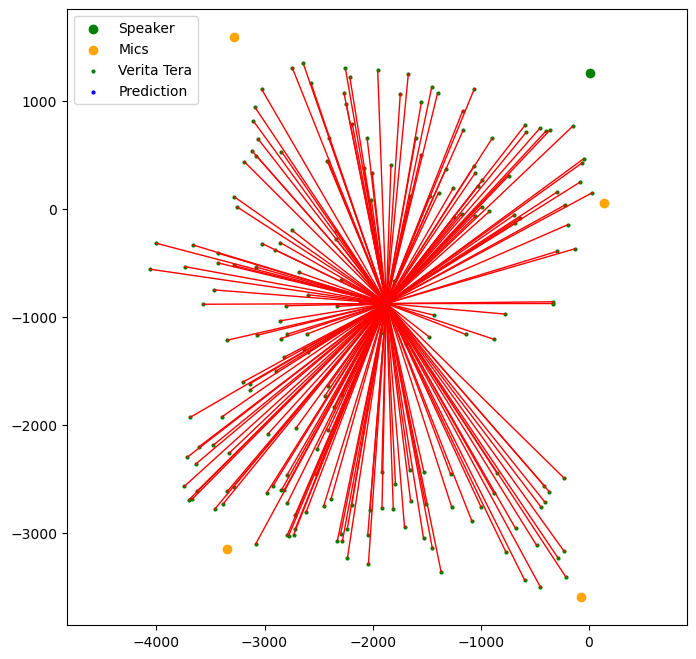

In [12]:
human1_dataset[0].room_setup.plot_prediction(y_pred, y_test)

max dist = 3022.505947602951
min dist = 62.28673923358099


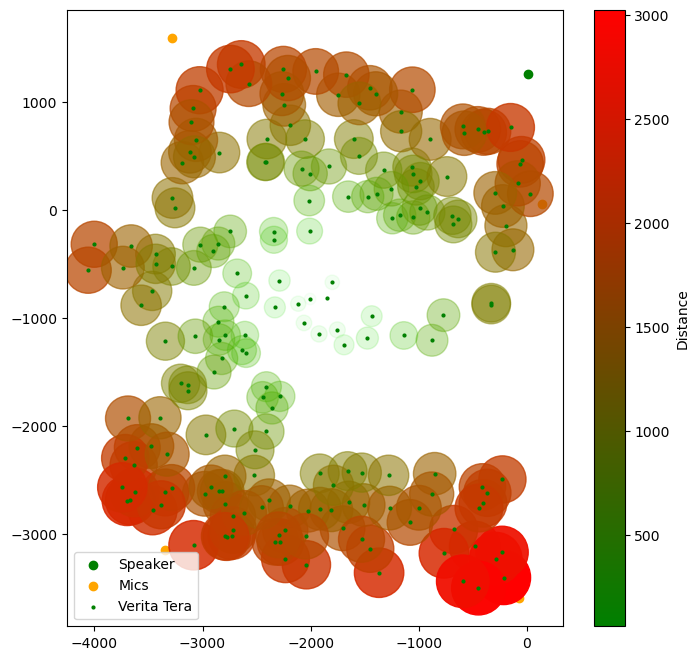

In [14]:
human1_dataset[0].room_setup.plot_heatmap(y_pred, y_test, avg)